In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

In [2]:
warnings.filterwarnings("ignore")

data = yf.download("F", start="2015-01-01", end="2025-01-01", progress=False)
data = data[['Close']]
data.fillna(method='ffill', inplace=True)

YF.download() has changed argument auto_adjust default to True


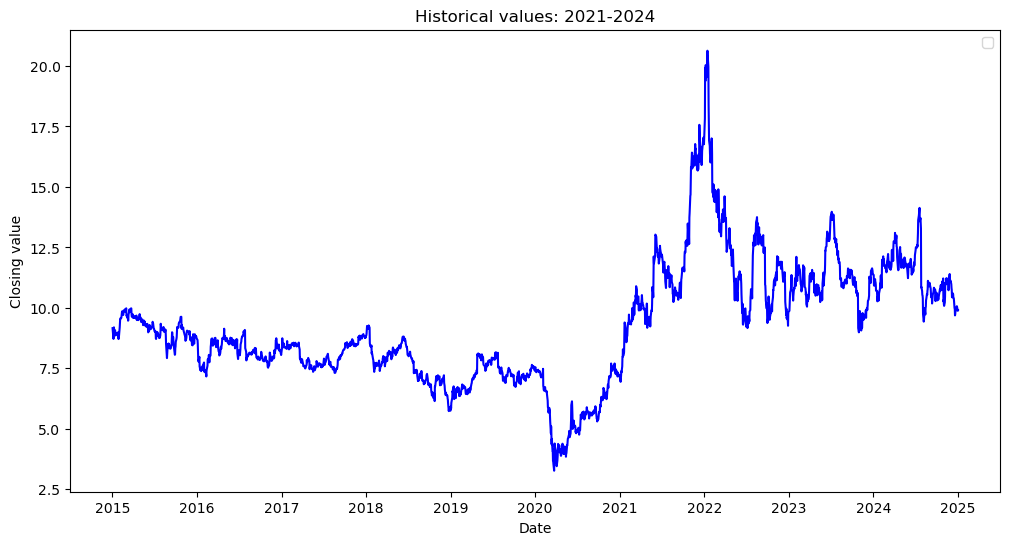

In [3]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], color = "blue")
plt.xlabel("Date")
plt.ylabel("Closing value")
plt.title("Historical values: 2021-2024")
plt.legend()
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_size = int(len(data['Close'])*0.7)
val_size = int(len(data['Close'])*0.15)
test_size = len(data['Close']) - train_size - val_size

train_data = data[['Close']][:train_size]
val_data = data[['Close']][train_size:train_size+val_size]
test_data = data[['Close']][train_size+val_size:]

scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_data)

# Avoid leakage by using the scaling parameters of the training set

val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

print(train_data.index)
print(val_data.index)
print(test_data.index)

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-20',
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-27',
               '2021-12-28', '2021-12-29'],
              dtype='datetime64[ns]', name='Date', length=1761, freq=None)
DatetimeIndex(['2021-12-30', '2021-12-31', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-10',
               '2022-01-11', '2022-01-12',
               ...
               '2023-06-16', '2023-06-20', '2023-06-21', '2023-06-22',
               '2023-06-23', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=377, freq=None)
DatetimeIndex(['2023-07-03', '2023-07-05', '2023-07-06', '2023-07-07',


In [5]:
def create_sequences(data, seq_length):

    Sequences = []
    targets = []

    for i in range(len(data)-seq_length):

        Sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])

    return np.array(Sequences), np.array(targets)

sequences_length = 100

X_train, y_train = create_sequences(train_scaled,sequences_length)
X_val, y_val = create_sequences(val_scaled,sequences_length)
X_test, y_test = create_sequences(test_scaled,sequences_length)

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, GRU, Dropout, Dense, Flatten

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7,
                               restore_best_weights=True)
p = 0.3 # controls dropout
epochs = 50
batch_size = 32
rate = 0.001
optimizer_lstm = Adam(learning_rate=rate)
optimizer_gru = Adam(learning_rate=rate)
optimizer_cnn_lstm = Adam(learning_rate=rate)

In [8]:
# LSTM

warnings.filterwarnings("ignore")
units = 100 # LSTM, GRU
d = 25 # Dense

model_lstm = Sequential([
    LSTM(units, return_sequences=True, input_shape = (sequences_length,1)),
    Dropout(p),
    LSTM(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer=optimizer_lstm, loss="mean_squared_error")

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# GRU

warnings.filterwarnings("ignore")
#units = 100

model_gru = Sequential([
    GRU(units, return_sequences=True, input_shape = (sequences_length,1)),
    Dropout(p),
    GRU(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer=optimizer_gru, loss="mean_squared_error")

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 100)       │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,051 (367.39 KB)

 Trainable params: 94,051 (367.39 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_cnn_lstm = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequences_length, 1)),  
    MaxPooling1D(pool_size=2),  
    LSTM(units, return_sequences=True),
    Dropout(p),
    LSTM(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation='relu'),
    Dense(1)
])

model_cnn_lstm.summary()

model_cnn_lstm.compile(optimizer=optimizer_cnn_lstm, loss="mean_squared_error")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 49, 100)        │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 49, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,279 (532.34 KB)

 Trainable params: 136,279 (532.34 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training LSTM

history_lstm = model_lstm.fit(
    X_train, y_train, validation_data=(X_val,y_val),
    epochs=epochs, batch_size=batch_size, callbacks = [early_stopping]
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0325 - val_loss: 0.0031
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 9.9822e-04 - val_loss: 0.0020
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss:

In [ ]:
# Training GRU

history_gru = model_gru.fit(
    X_train, y_train, validation_data=(X_val,y_val),
    epochs=epochs, batch_size=batch_size, callbacks = [early_stopping]
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0290 - val_loss: 0.0013
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 8.9151e-04 - val_loss: 9.9348e-04
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 9.7924e-04 - val_loss: 0.0021
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 8.4455e-04 - val_loss: 0.0013
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 7.5789e-04 - val_loss: 9.1892e-04
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 7.6033e-04 - val_loss: 0.0012
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━

In [ ]:
# Trainning CNN-LSTM

history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train, validation_data=(X_val,y_val),
    epochs=epochs, batch_size=batch_size, callbacks = [early_stopping]
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 312ms/step - loss: 0.0244 - val_loss: 0.0071
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 311ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - loss: 0.0025 - val_loss: 0.0056
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 318ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 304ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 310ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 306ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 319ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16

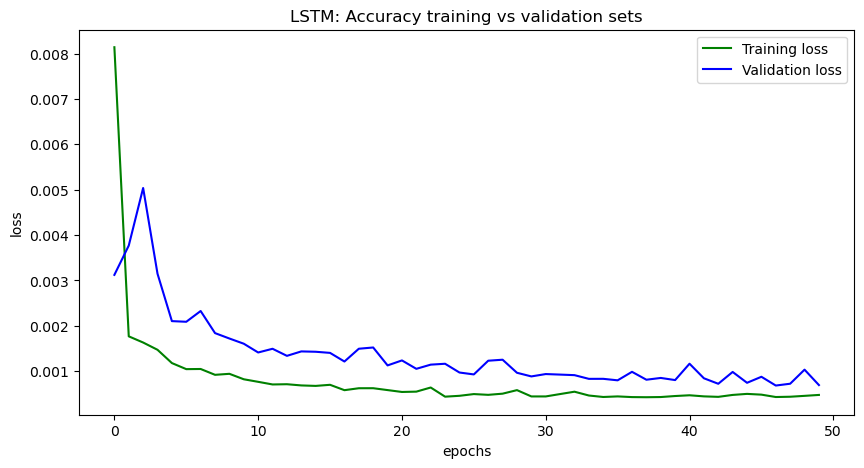

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['loss'], color="green", label = "Training loss")
plt.plot(history_lstm.history['val_loss'], color="blue", label = "Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM: Accuracy training vs validation sets")
plt.legend()
plt.show()

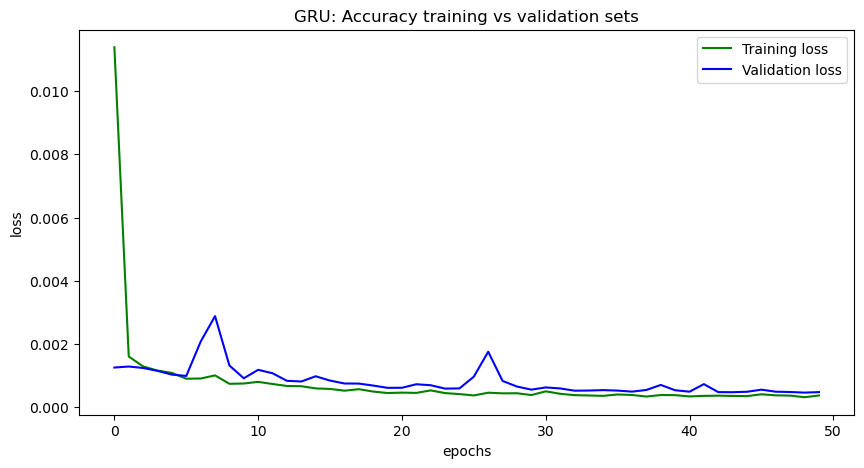

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_gru.history['loss'], color="green", label = "Training loss")
plt.plot(history_gru.history['val_loss'], color="blue", label = "Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("GRU: Accuracy training vs validation sets")
plt.legend()
plt.show()

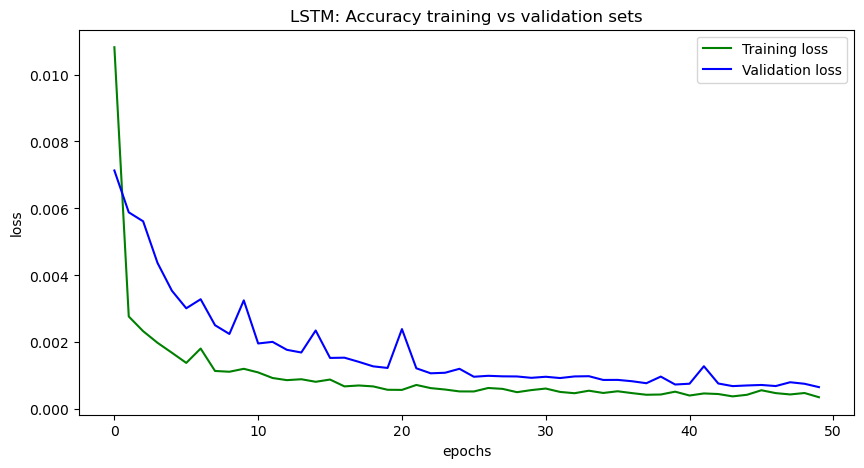

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_cnn_lstm.history['loss'], color="green", label = "Training loss")
plt.plot(history_cnn_lstm.history['val_loss'], color="blue", label = "Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM: Accuracy training vs validation sets")
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


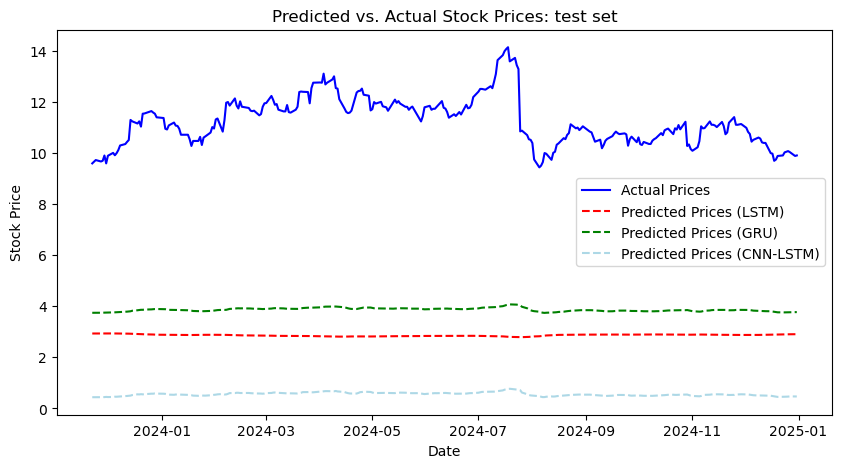

In [ ]:
# Predictions
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)
test_dates = data.index[train_size + val_size + sequences_length:]

# Inverse transform predictions & actuals
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_pred_gru = scaler.inverse_transform(y_pred_gru.reshape(-1, 1))
y_pred_cnn_lstm = scaler.inverse_transform(y_pred_cnn_lstm.reshape(-1, 1))


# Plots

plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(test_dates, y_pred_lstm, label="Predicted Prices (LSTM)", color="red", linestyle="dashed")
plt.plot(test_dates, y_pred_gru, label="Predicted Prices (GRU)", color="green", linestyle="dashed")
plt.plot(test_dates, y_pred_cnn_lstm, label="Predicted Prices (CNN-LSTM)", color="lightblue", linestyle="dashed")
plt.legend()
plt.title("Predicted vs. Actual Stock Prices: test set")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_lstm = mean_squared_error(y_test_rescaled, y_pred_lstm, squared=False)
rmse_gru = mean_squared_error(y_test_rescaled, y_pred_gru, squared=False)
rmse_cnn_lstm = mean_squared_error(y_test_rescaled, y_pred_cnn_lstm, squared=False)

mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_lstm)
mae_gru = mean_absolute_error(y_test_rescaled, y_pred_gru)
mae_cnn_lstm = mean_absolute_error(y_test_rescaled, y_pred_cnn_lstm)

print(f"RMSE (LSTM): {rmse_lstm:.4f}")
print(f"RMSE (GRU): {rmse_gru:.4f}")
print(f"RMSE (LSTM): {rmse_cnn_lstm:.4f}")
print(f"MAE (LSTM): {mae_lstm:.4f}")
print(f"MAE (GRU): {mae_gru:.4f}")
print(f"MAE (LSTM): {mae_cnn_lstm:.4f}")
